In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy

import sys
from pathlib import Path
sys.path.insert(0, str(Path().resolve().parents[1]))
from model import left_right_task as lrt, network_model, util, plot_style

Wji, pset, amp, dur, l_kernel, r_kernel = util.load_fiducial_network(True)

In [2]:
import os
os.getcwd()

'c:\\Users\\caele\\Documents\\miller-lab-final\\figures\\figure7'

In [3]:
def plot_reliabilities(ax, path):
    # load reliabilities
    reliabilities = np.load(path + '/reliabilities.npy')
    dur_mesh = np.load(path + '/dur_mesh.npy')
    amp_mesh = np.load(path + '/amp_mesh.npy')
    
    # plot
    c = ax.pcolormesh(dur_mesh, amp_mesh, reliabilities.reshape(dur_mesh.shape), cmap='viridis', shading='auto')
    ax.set_yscale('log')
    ax.set_xlabel(r"$\tau_{dur}$")
    ax.set_ylabel(r"$I_{app}$")
    
    return c


In [52]:
reliabilities_7A = np.load('data_7A/reliabilities.npy')
dur_mesh_7A = np.load('data_7A/dur_mesh.npy')
amp_mesh_7A = np.load('data_7A/amp_mesh.npy')

# find the maxima of the reliability
max_reliability = np.max(reliabilities_7A)
max_indices = np.argsort(reliabilities_7A)[-10:]
print(f"Top 10 reliabilities: {reliabilities_7A[max_indices]}")
max_dur = dur_mesh_7A.flatten()[max_indices]
max_amp = amp_mesh_7A.flatten()[max_indices]
print(f"Max reliability: {max_reliability} at dur={max_dur}, amp={max_amp}")

Top 10 reliabilities: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
Max reliability: 1.0 at dur=[0.00408163 0.00102041 0.00204082 0.00714286 0.00306122 0.00204082
 0.02755102 0.00102041 0.00714286 0.00510204], amp=[ 5.96362332  8.68511374  7.19685673 16.76832937  6.55128557  6.55128557
 16.76832937  9.54095476 15.26417967  5.96362332]


In [56]:
amps = np.load('data_7BE/amps.npy')
kernel_ids = np.load('data_7BE/kernel_ids.npy')
p_curves = np.load('data_7BE/p_curves.npy')
reliabilities = np.load('data_7BE/reliabilities.npy')
df_decisions = pd.read_csv('data_7BE/decision_dicts.csv')

In [61]:
df_decisions.index = lrt.make_all_sequences(6, ['L', 'R'])

In [101]:
def p_congruent(ax, columns, reliabilities, seq_len=6, color='blue'):
    # columns is a subset of a DataFrame with decisions
    prob_congruent = np.zeros((seq_len, len(columns.columns))) # rows: position in sequence, cols: different networks
    for i in range(seq_len):
        cue = [s[i] for s in columns.index]
        for j, col in enumerate(columns.columns):
            decisions = columns[col].values
            congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
            prob_congruent[i, j] = np.mean(congruent)

    prob_congruent = prob_congruent
    ax.plot(np.arange(seq_len) + 1, prob_congruent, color='gray', alpha=1/len(reliabilities))
    ax.plot(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1), '-o', color=color, label='Mean')
    sem_pc = scipy.stats.sem(prob_congruent, axis=1)
    ax.fill_between(np.arange(seq_len) + 1, np.mean(prob_congruent, axis=1) - 1.96 * sem_pc, np.mean(prob_congruent, axis=1) + 1.96 * sem_pc, color=color, alpha=0.2, label='95% CI')
    ax.set_xlabel('Cue number')
    ax.legend()

In [ ]:
from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    From:
    https://matplotlib.org/stable/gallery/lines_bars_and_markers/multicolored_line.html

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [143]:
def recency_score(columns):
    # columns is a subset of a DataFrame with decisions
    recency_scores = np.zeros(len(columns.columns))
    # compute the probability of congruent decisions for only the last cue
    cue = [s[-1] for s in columns.index]
    for j, col in enumerate(columns.columns):
        decisions = columns[col].values
        congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
        recency_scores[j] = np.mean(congruent)
    
    recency_scores = recency_scores
    return recency_scores

def plot_recency(ax, amps, df_decisions, reliabilities, n_kernels=10):
    # get recency scores for each amplitude
    recency_scores = np.zeros((len(np.unique(amps)), n_kernels))
    for i, amp in enumerate(np.unique(amps)):
        columns = df_decisions[df_decisions.columns[amps == amp]]
        recency_scores[i] = recency_score(columns)
    ax.plot(np.unique(amps), recency_scores, color='grey', alpha=0.05)
    reliabilities_by_amp = np.array([reliabilities[amps == amp].mean() for amp in np.unique(amps)])
    colored_line(np.unique(amps), np.mean(recency_scores, axis=1), reliabilities_by_amp, 
                 ax, linewidth=2, label='Mean', cmap='viridis')
    sem_rc = scipy.stats.sem(recency_scores, axis=1)
    ax.fill_between(np.unique(amps), np.mean(recency_scores, axis=1) - 1.96 * sem_rc, np.mean(recency_scores, axis=1) + 1.96 * sem_rc, 
                    color='blue', alpha=0.2, label='95% CI')
    ax.set_ylabel('Recency score')
    ax.set_xscale('log') 

def primacy_score(columns):
    # columns is a subset of a DataFrame with decisions
    primacy_scores = np.zeros(len(columns.columns))
    # compute the probability of congruent decisions for only the last cue
    cue = [s[0] for s in columns.index]
    for j, col in enumerate(columns.columns):
        decisions = columns[col].values
        congruent = [0.5 if d == 'Tie' else (1 if (d == c) else 0) for c, d in zip(cue, decisions)]
        primacy_scores[j] = np.mean(congruent)
    
    primacy_scores = primacy_scores
    return primacy_scores

def plot_primacy(ax, amps, df_decisions, reliabilities, n_kernels=10):
    # get recency scores for each amplitude
    primacy_scores = np.zeros((len(np.unique(amps)), n_kernels))
    for i, amp in enumerate(np.unique(amps)):
        columns = df_decisions[df_decisions.columns[amps == amp]]
        primacy_scores[i] = primacy_score(columns)
    ax.plot(np.unique(amps), primacy_scores, color='grey', alpha=0.05)
    reliabilities_by_amp = np.array([reliabilities[amps == amp].mean() for amp in np.unique(amps)])
    colored_line(np.unique(amps), np.mean(primacy_scores, axis=1), reliabilities_by_amp, 
                 ax, linewidth=2, label='Mean', cmap='viridis')
    sem_rc = scipy.stats.sem(primacy_scores, axis=1)
    ax.fill_between(np.unique(amps), np.mean(primacy_scores, axis=1) - 1.96 * sem_rc, np.mean(primacy_scores, axis=1) + 1.96 * sem_rc, 
                    color='blue', alpha=0.2, label='95% CI')
    ax.set_ylabel('Primacy score')
    ax.set_xscale('log')

In [205]:
import networkx as nx
def plot_FSM(FSM, ax, color_map={'L': 'blue', 'R': 'red'}, connection_map={'L': 'arc3,rad=0.2', 'R': 'arc3,rad=0.2'}, node_size=800, font_size=None,
             layout=nx.kamada_kawai_layout):
    if font_size is None:
        font_size = plt.rcParams['font.size']
    left_edges = []
    right_edges = []
    l_self_edges = []
    r_self_edges = []
    for edge in FSM.edges:
        if FSM.edges[edge]['label'] == 'L':
            if edge[0] == edge[1]:
                l_self_edges.append(edge)  
            else:
                left_edges.append(edge)
        else:
            if edge[0] == edge[1]:
                r_self_edges.append(edge)
            else:
                right_edges.append(edge)
    
    pos = layout(FSM)
    nx.draw_networkx_nodes(FSM, pos, ax=ax, node_size=node_size)
    nx.draw_networkx_edges(FSM, pos, edgelist=left_edges, edge_color=color_map['L'], connectionstyle=connection_map['L'], ax=ax,
                           arrowsize=5,
                           node_size=node_size)
    nx.draw_networkx_edges(FSM, pos, edgelist=right_edges, edge_color=color_map['R'], connectionstyle=connection_map['R'], ax=ax,
                           arrowsize=5,
                           node_size=node_size)
    nx.draw_networkx_edges(FSM, pos, edgelist=l_self_edges,
                           edge_color='blue',
                           connectionstyle='arc3,rad=0.1',
                           arrowsize=5,
                           ax=ax, node_size=node_size
                        )
    nx.draw_networkx_edges(FSM, pos, edgelist=r_self_edges,
                           edge_color='red',
                           arrowsize=5,
                           ax=ax, node_size=node_size
                        )
    nx.draw_networkx_labels(FSM, pos, ax=ax, font_size=font_size, font_color='white')

In [169]:
# task parameters
numPairs = 5
dt = 1e-5
seq_len = 6
sequences = lrt.make_all_sequences(seq_len, ['L', 'R'])
equil_duration = 2

# make sample FSMs
FSMs = []
for i, amp in enumerate(np.unique(amps)[[4, 5, 9]]):
    stim_map = lrt.make_stim_map(numPairs, amp, dur, l_kernel, r_kernel, dt)
    FSM = lrt.make_FSM(numPairs, pset, Wji, stim_map, equil_duration, dt)
    FSMs.append(FSM)

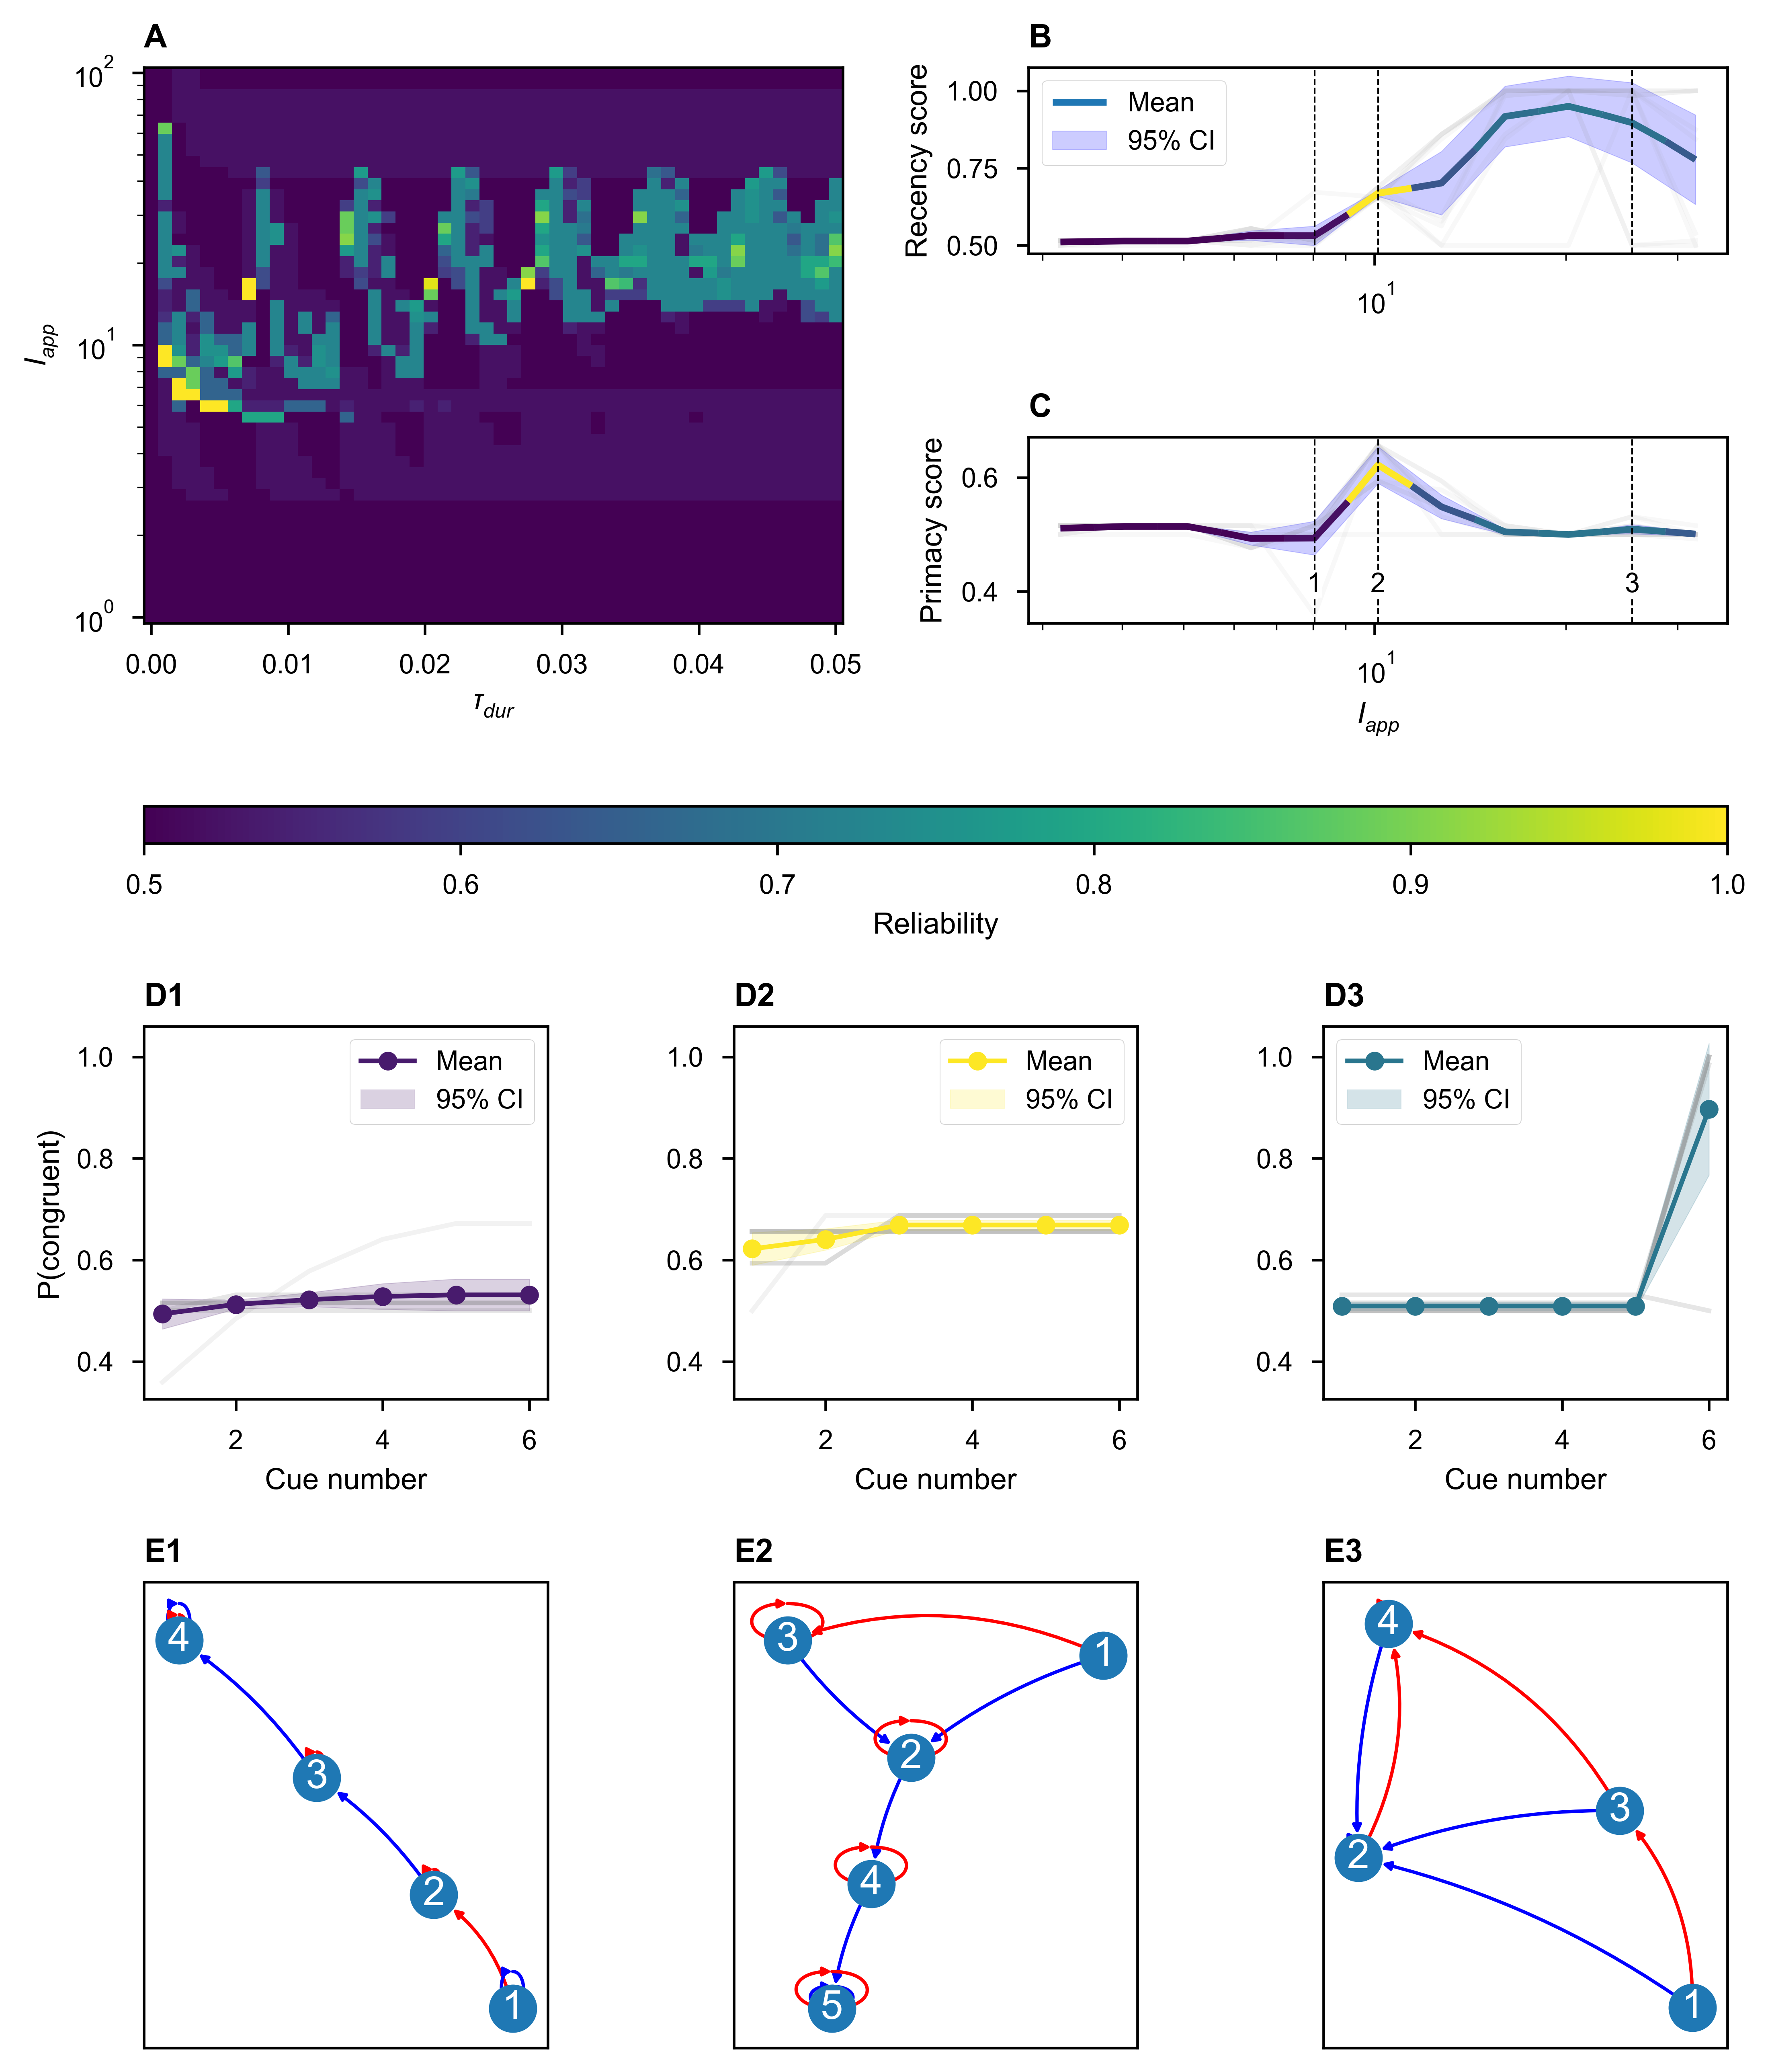

In [207]:
MIN_WIDTH = 1578    # in pixels at 600 dpi
MAX_WIDTH = 4500
MAX_HEIGHT = 5250

px = 1/plt.rcParams['figure.dpi']   # convert pixel to inches
fig = plt.figure(layout='tight', figsize=(MAX_WIDTH*px, MAX_HEIGHT*px))
axd = fig.subplot_mosaic(
    """
    AAABBB
    AAACCC
    xxxxxx
    DDddbb
    EEeeii
    """,
    height_ratios=[1,1,0.2,2,2.5]
)
label_dict = {l: l for l in axd.keys()}
label_dict['D'] = 'D1'
label_dict['d'] = 'D2'
label_dict['b'] = 'D3'
axd['D'].sharey(axd['d'])
axd['d'].sharey(axd['b'])
label_dict['E'] = 'E1'
label_dict['e'] = 'E2'
label_dict['i'] = 'E3'
for label, ax in axd.items():
    if label in ('x'):
        continue
    ax.set_title(label_dict[label], loc='left', fontweight='bold')

c = plot_reliabilities(axd['A'], 'data_7A')
cbar = fig.colorbar(c, cax=axd['x'], location='bottom', aspect=20)
cbar.set_label('Reliability')

samples = [4, 5, 9]
d_axes = [axd['D'], axd['d'], axd['b']]
for count, i in enumerate(samples):
    ax = d_axes[count]
    p_congruent(ax, df_decisions[df_decisions.columns[10*i:10*(i+1)]], reliabilities[10*i:10*(i+1)], seq_len=6,
            color=c.cmap(c.norm(reliabilities[10*i:10*(i+1)].mean())))
    if count == 0:
        ax.set_ylabel('P(congruent)')

plot_recency(axd['B'], amps, df_decisions, reliabilities, n_kernels=10)
plot_primacy(axd['C'], amps, df_decisions, reliabilities, n_kernels=10)
axd['B'].sharex(axd['C'])
axd['C'].set_xlabel(r"$I_{app}$")
axd['B'].legend()
# add vertical lines for the sample FSMs
for count, i in enumerate(samples):
    axd['B'].axvline(x=np.unique(amps)[i], color='black', linestyle='--', linewidth=0.5)
    axd['C'].axvline(x=np.unique(amps)[i], color='black', linestyle='--', linewidth=0.5)
    # annotate
    axd['C'].annotate(f'{count+1}', xy=(np.unique(amps)[i], 0.39), xytext=(np.unique(amps)[i], 0.39),
                      textcoords='data', ha='center', va='bottom', fontsize=8, color='black',
                      bbox=dict(facecolor='white', edgecolor='white', boxstyle='round,pad=0'))

e_axes = [axd['E'], axd['e'], axd['i']]
for i, FSM in enumerate(FSMs):
    layout = nx.kamada_kawai_layout if i == 1 else nx.spring_layout
    plot_FSM(FSM, e_axes[i], node_size=200, connection_map={'L': 'arc3,rad=0.1', 'R': 'arc3,rad=0.2'}, layout=layout)

plt.show()